In [72]:
library(parallel)
source('PTrees.R')
source('Datasets.R')
library(class)
source('PTrees_General.R')

In [2]:
#P1: predict whether to stop
dtree_helper <- function(t, dataset, fixed_params, predictors){
    data <- dataset$data
    x_names <- dataset$x_names
    y_names <- dataset$y_names
    rng <- dataset$rng
    ys <- get(y_names, data)
    t$nrows <- Inf
    effects <- predictors$P1(t, dataset, fixed_params)
    fixed_params$epsilon <- fixed_params$epsilon-effects$used
    if(fixed_params$dep == 0 || effects$action == 1){ #t$nrows < params$sigma
        get_leaf_node(ys, t, fixed_params$epsilon)
        return()
    }
    fixed_params$dep <- fixed_params$dep-1
    attr_best <- 0
    if(effects$action==2){
        atp <- lapply(x_names, function(name) cond_eval(name, data, rng, ys))
        utilities <- sapply(atp, function(x) -x$ent)
        attr_best <- exp_mech(atp, utilities, fixed_params$query_budget, ent_util$sens)
        fixed_params$epsilon <- fixed_params$epsilon-fixed_params$query_budget
    }else{
        name <- sample(x_names, 1)
        attr_best <- cond_eval(name, data, range_bounds, ys)
    }
    t$name <- paste(t$name, attr_best$name, sep=';')
    t$pars <- split(attr_best)
    t$attr <- attr_best$name
    col <- get(attr_best$name, data)
    dataset$x_names <- x_names[x_names != attr_best$name]
    for(fn in t$pars){
        subset <- (fn$fn)(col)
        dataset$data <- data[subset, ]
        dtree_helper(t$AddChild(fn$name), dataset, fixed_params, predictors)
    }
}

dtree_outer <- function(dataset, dep, epsilon, predictors){
    dt <- Node$new('')
    params <- list(collect_size=TRUE, sigma=0, query_budget=epsilon/(2*(dep+1)), num_attr=length(dataset$x_names),
                   epsilon=epsilon, dep=dep)
    if(TRUE){
        params$sigma <- get_sigma(dataset$data, dataset$x_names, dataset$y_names) / params$query_budget
        dtree_helper(dt, dataset,  params, predictors)
        if(FALSE){
            prune_tree(dt, y_name %>% get(data) %>% levels)
        }   
    }else{
        params$collect_size <- FALSE
        params$query_budget <- params$query_budget*2
        dtree_helper(dt, dataset, params, predictors)
    }
    return(dt)
}

In [8]:
S2 <- split_data(ttt, 0.7)
alg_1 <- list(P1=function(t, dataset, fixed_params){
    t$nrows <- hist_noiser(nrow(dataset$data), fixed_params$query_budget)
    a <- 1
    if(t$nrows >= fixed_params$sigma)
        a <- 2
    return(list(action=a, used=fixed_params$query_budget))
})
t <- dtree_outer(S2$train, 5, 5, alg_1)
test_tree(t, S2$test)

[1] 0.7465278

In [67]:
alg_2 <- list(P1=function(t, dataset, fixed_params){
    t$nrows <- hist_noiser(nrow(dataset$data), fixed_params$query_budget/2)
    if(t$nrows < 20){
        return(list(action=1, used=fixed_params$query_budget/2))
    }else{
        cur_ent <- get_ent(table(get(dataset$y_names, dataset$data)))
        a <- exp_mech(c(1, 2), c(1, 2*cur_ent), fixed_params$query_budget/2, sens=ent_util$sens)
        return(list(action=a, used=fixed_params$query_budget))
    }
})

In [73]:
eps_test <- c(0.5, 1:10)
P1 <- get_data(S2, eps_test, alg_1, "Nrow", 5, 50)
P2 <- get_data(S2, eps_test, alg_2, "Size", 5, 50)

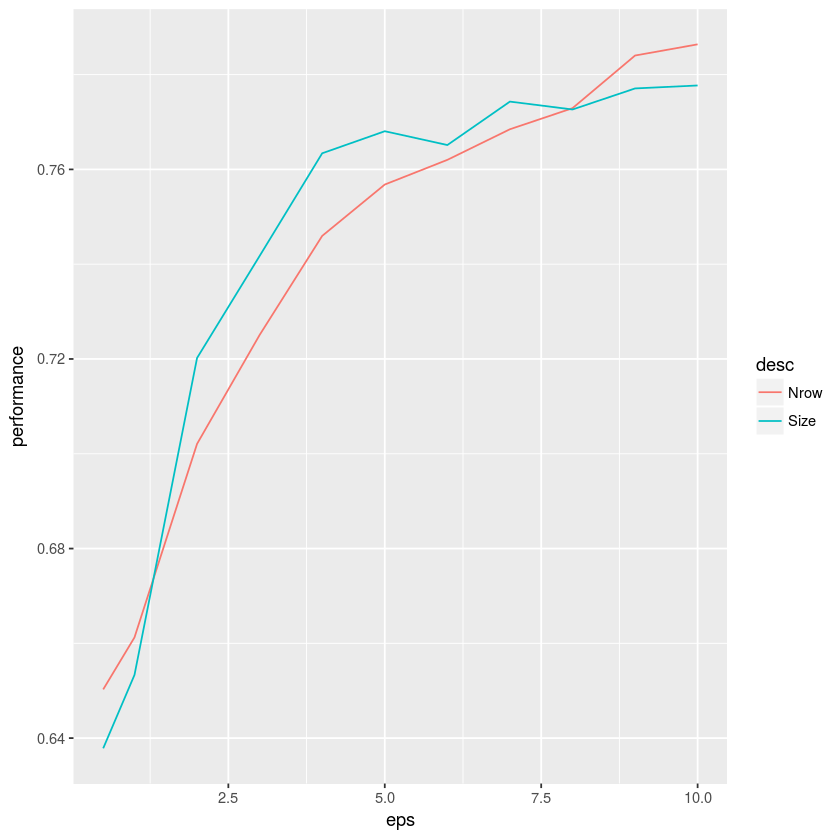

In [74]:
get_plot(rbind(P1, P2))

In [ ]:
#What will allow me to do maximal data exploration?

In [114]:
get_max_app <- function(ys, eps){
    m <- data.frame(table(ys))
    counts <- hist_noiser(m$Freq, eps)
    idx <- which.max(counts)
    guess <- m$ys[idx]
    return(guess)
}
dtree_helper_train <- function(data, params, validation){
    x_names <- params$x_names
    ys <- get(params$y_names, data)
    ysv <- get(params$y_names, validation)
    nrows <- hist_noiser(nrow(data), params$query_budget)
    params$epsilon <- params$epsilon-params$query_budget
    guess <- get_max_app(ys, params$epsilon)
    leaf_performance <- sum(ysv == guess)
    if(params$dep == 0 || nrows < 20)
        return(list(per=leaf_performance, data=data.frame()))
    atp <- lapply(x_names, function(name) cond_eval(name, data, params$rng, ys))
    utilities <- sapply(atp, function(x) -x$ent)
    attr_exp <- exp_mech(atp, utilities, params$query_budget, ent_util$sens)
    attr_rand <- sample(atp, 1)[[1]]
    attr <- 0
    idx <- 1
    if(runif(1) < 0.5){
        attr <- attr_exp
        params$epsilon <- params$epsilon-params$query_budget
    }else{
        attr <- attr_rand
        idx <- 2
    }
    stop_performance <- sum(guess == ysv)
    pars <- split(attr)
    tot_right <- 0
    rec_calls <- data.frame()
    params$x_names <- x_names[x_names != attr$name]
    params$dep <- params$dep-1
    col_train <- get(attr$name, data)
    col_test <- get(attr$name, validation)
    for(fn in pars){
        L <- dtree_helper_train(data[fn$fn(col_train), ], params, validation[fn$fn(col_test), ])
        tot_right <- tot_right+L$per
        rec_calls <- rbind(rec_calls, L$data)
    }
    rec_calls <- rbind(rec_calls, 
                       data.frame(right_branch=tot_right / nrow(validation), 
                                  leaf=leaf_performance / nrow(validation),
                                  nrow=nrows,
                                  dep=params$dep,
                                  idx=idx,
                                  cur_ent=get_ent(table(ys)),
                                  dim=length(data)-1,
                                  c_size = levels(ys) %>% length,
                                  a_size=sapply(data[,x_names], function(r) r %>% levels %>% length %>% log) %>% reduce (`+`)
                                 ))
    return(list(per=tot_right, data=rec_calls))
}
dtree_outer_train <- function(dataset, dep, epsilon){
    params <- list(collect_size=TRUE, sigma=0, query_budget=epsilon/(2*(dep+1)), dep=dep, epsilon=epsilon,
                  x_names=dataset$train$x_names, y_names=dataset$train$y_names)
    if(TRUE){
        return(dtree_helper_train(dataset$train$data, params, dataset$test$data)$data)
        if(FALSE){
            prune_tree(dt, y_name %>% get(data) %>% levels)
        }
    }else{
        params$collect_size <- FALSE
        params$query_budget <- params$query_budget*2
        #dtree_helper_train(data, test, attrs, y_name, dep, epsilon, params)
    }
}

In [115]:
sapply(bind$data[,bind$x_names], function(r) r %>% levels %>% length %>% log) %>% reduce(`+`)

[1] 23.96586

In [125]:
set.seed(12345)
S1 <- split_data(bind, 0.7)
S2 <- split_data(ttt, 0.7)
S3 <- split_data(nurs, 0.5)
S4 <- split_data(contra, 0.7)
S5 <- split_data(loan, 0.7)
S6 <- split_data(student, 0.7)
D1 <- dtree_outer_train(S1, 5, 5)
D2 <- dtree_outer_train(S2, 5, 5)
D3 <- dtree_outer_train(S3, 5, 5)
D4 <- dtree_outer_train(S4, 5, 5)
D5 <- dtree_outer_train(S5, 5, 5)
D6 <- dtree_outer_train(S6, 5, 5)

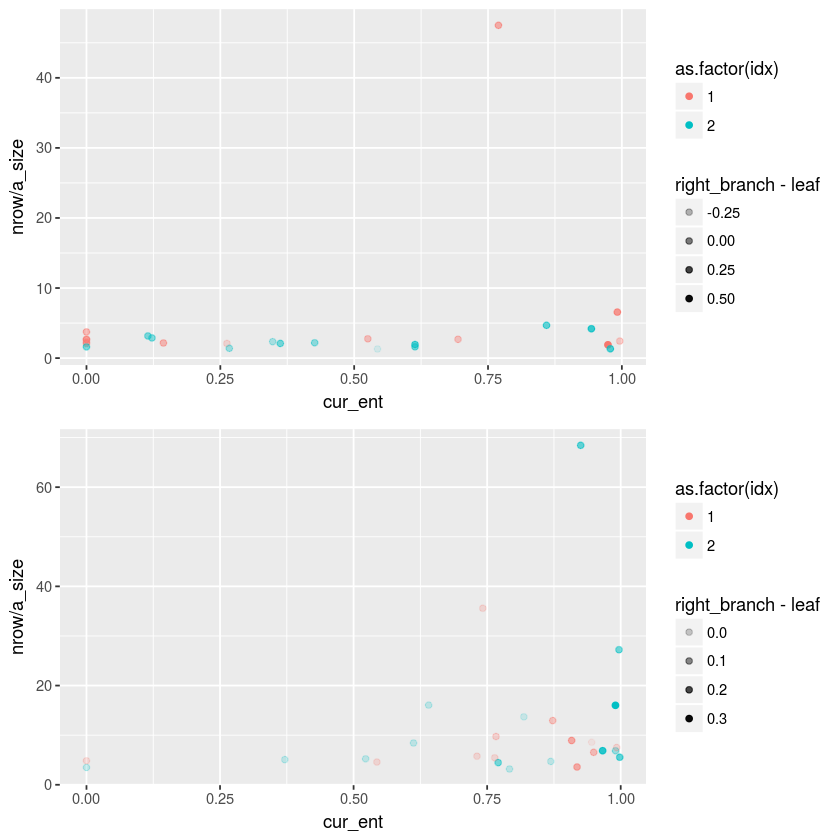

In [126]:
p1 <- ggplot(D1, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
p2 <- ggplot(D2, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
p3 <- ggplot(D3, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
p4 <- ggplot(D4, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
multiplot(p1, p2)

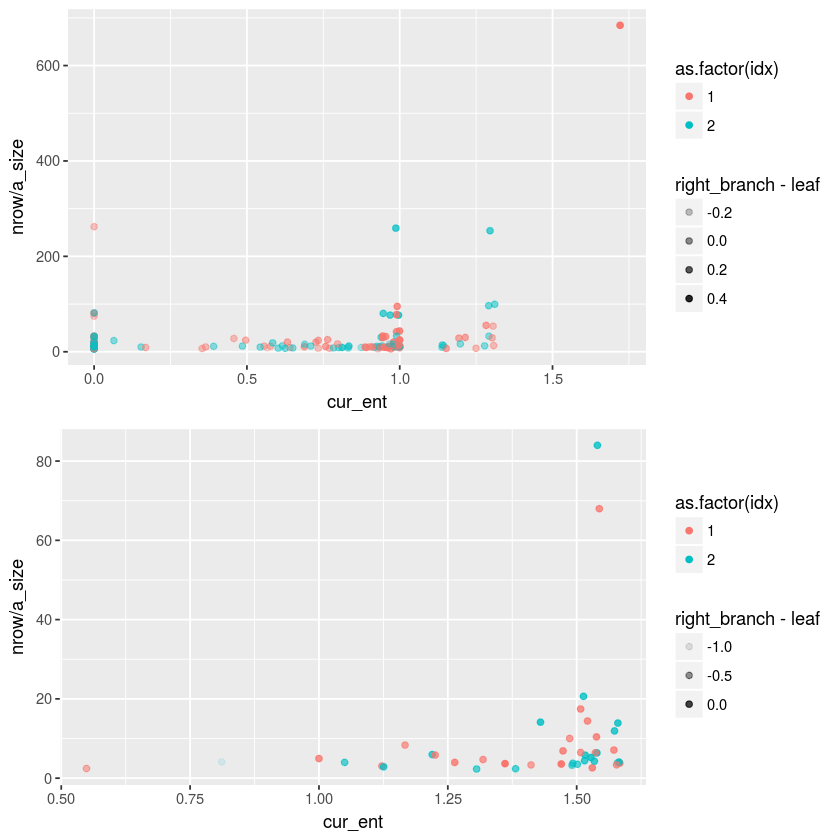

In [127]:
multiplot(p3, p4)

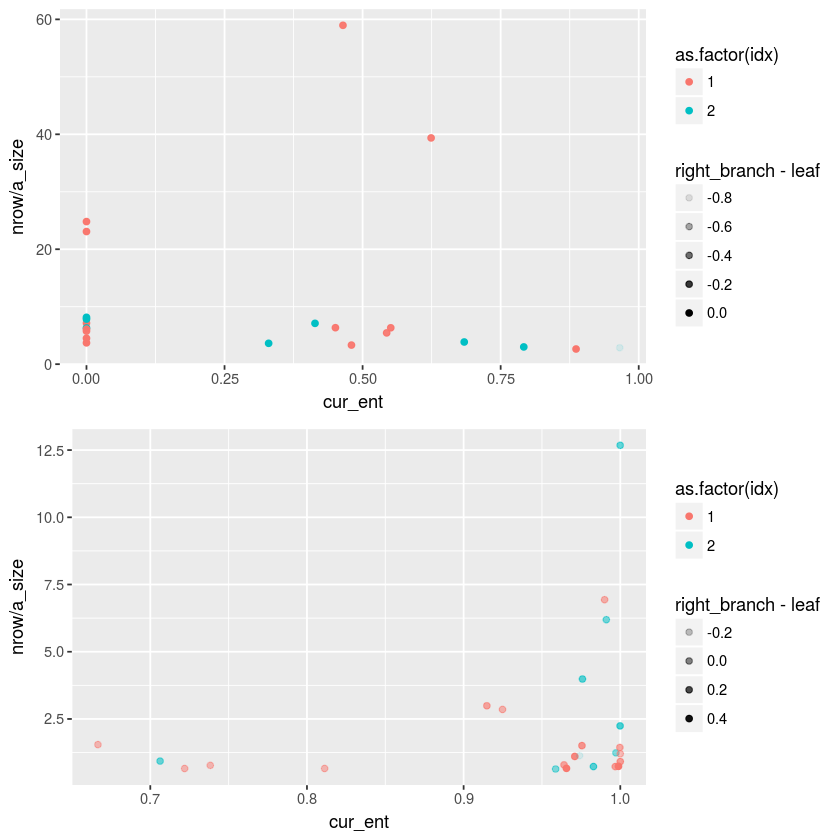

In [129]:
p5 <- ggplot(D5, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
p6 <- ggplot(D6, aes(x=cur_ent, y=nrow / a_size, color=as.factor(idx), alpha=right_branch-leaf)) + geom_point()
multiplot(p5, p6)

In [ ]:
#dtree_general_train(S1, 5, 5)
#dtree_general_train(S2, 5, 5)
#dtree_general_train(S3, 5, 5)
#dtree_general_train(S4, 5, 5)
#dtree_general_train(S5, 5, 5)
#dtree_general_train(S6, 5, 5)

In [101]:
L3 <- mutate(L3, best=as.factor(best), )

In [102]:
L3_data <- data.frame(nrow=L3$nrow %>% log10, pct=L3$attrs_left / L3$attr_size)

In [157]:
eps_test <- c(0.5, 1:10)
predict1 <- list(L4=function(params){
    a <- knn(L3_data, data.frame(nrow=params$nrow %>% log10, pct=params$attr_left / params$num_attr), L3$best, k=1) %>% as.integer
    return(a)
})
T1 <- get_data(S3, eps_test, function(d, b, dep){dtree_general(d,b,dep,predict1)}, "Learning")
predict2 <- list(L4=function(params){
    if(params$nrow < params$sigma)
        return(1)
    else
        return(2)
})
T2 <- get_data(S3, eps_test, function(d, b, dep){dtree_general(d,b,dep,predict2)}, "No Learning, stopping")
predict3 <- list(L4=function(params){
    return(2)
})
T3 <- get_data(S3, eps_test, function(d, b, dep){dtree_general(d,b,dep,predict3)}, "No Learning, no stopping")

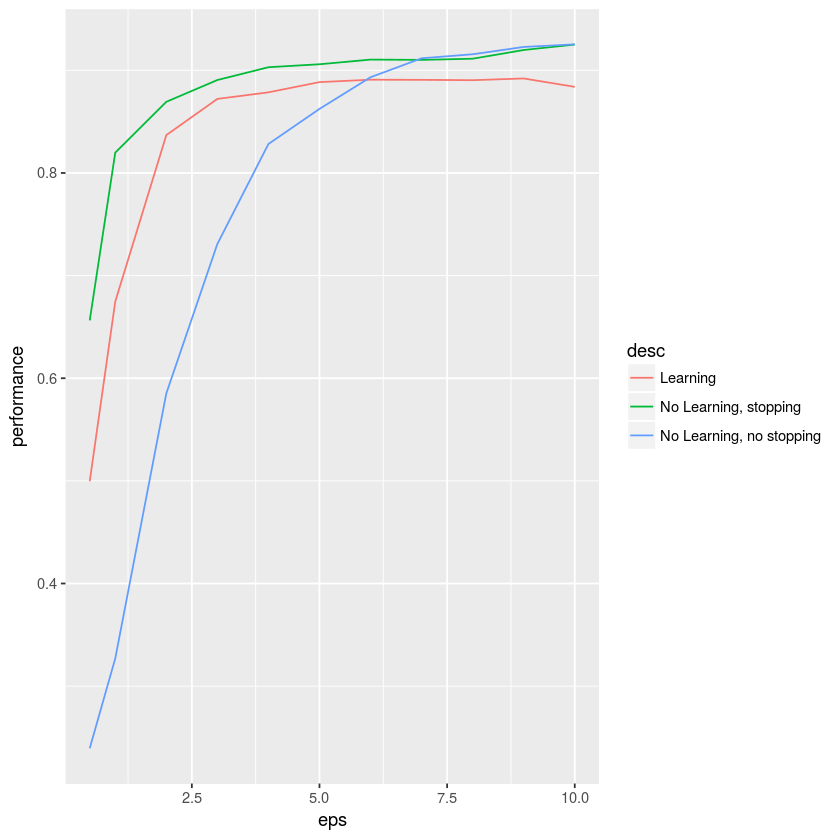

In [159]:
get_plot(rbind(T1, T2, T3))

In [153]:
dt_gen <- function(d, b, dep){dtree_general(d,b,dep,predict1)}
G <- mapply(function(...) sapply(eps_test, function(e){test(S3, e, 5, dt_gen)}), 1:10)

In [155]:
DF <- data.frame(eps=eps_test, performance=rowMeans(G), desc="Learning")

In [141]:
ys <- get(S3$test$y_names, S3$test$data)
sum(predict(t, S3$test$data, ys[1]) == ys)
sum(predict(t2, S3$test$data, ys[1]) == ys)
sum(predict(t3, S3$test$data, ys[1]) == ys)

[1] 5649

[1] 5910

[1] 5883

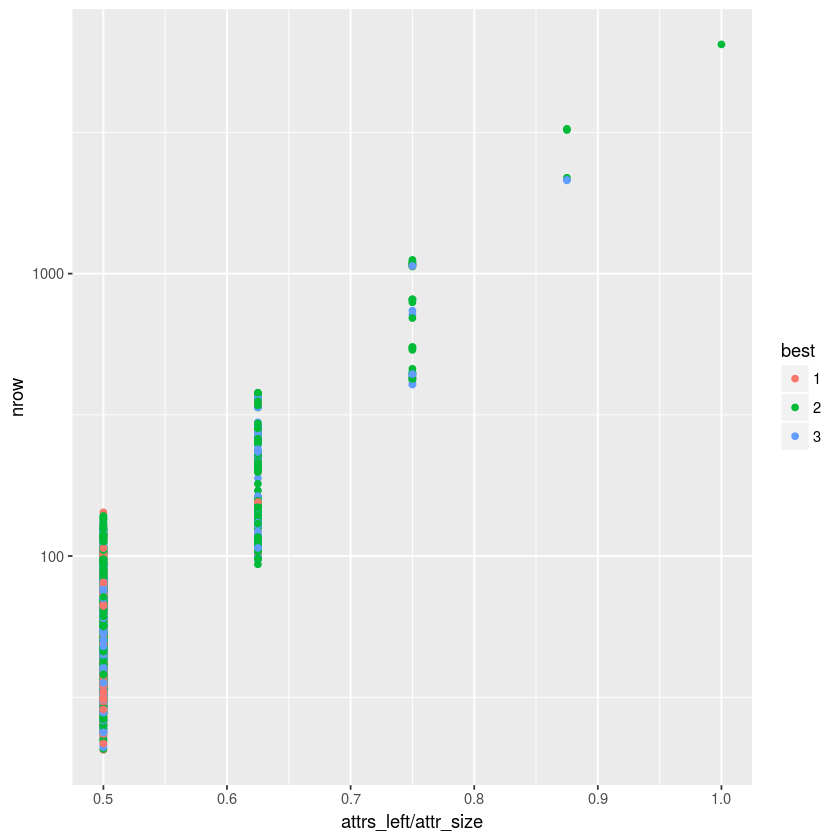

In [104]:
ggplot(L3, aes(x=attrs_left / attr_size, y=nrow, color=best))+geom_point() +scale_y_log10()

In [163]:
#Is knn the problem? Could I do it manually?
#Get a draft of everything I've done so far before I'm gone (version of my thesis to send to Jean)
#Meet with Matt while I'm at home
#Ask my mom if Jean can talk to her
#How hands-on are the professors with their students? How much meeting time vs 
#How technical are they? How many do they currently have?
#What is the group culture like? Ask to talk to the students.

In [ ]:
#Email Matt and Arthur about any suggestions they may have for improvement